This is the script to build and train convnet model which categorize between class: building, not building model is then saved to ./models folder

In [1]:
import os
import tensorflow as tf

In [ ]:
# import dataset from directory
DIR_PATH = os.path.join('cleaned_data', 'building_dataset_all')
IMAGE_SIZE = 244
BATCH_SIZE = 32
# =============================
# Create Image Dataset form Directory
# =============================
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_PATH,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='training'

)
ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_PATH,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='validation'
)


In [ ]:
# Visualize data
images = None
labels = None
class_names = ds_train.class_names
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
# data augmentation
with tf.device('/CPU:0'): # for Apple Silicon which does not yet support random() with GPU
    augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.4, 0.6)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0, -0.2),
                                                              width_factor=(0, -0.2)),
    ])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

augmented_ds_train = ds_train.map(
    lambda x, y: (augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

augmented_ds_train = augmented_ds_train.cache()
augmented_ds_train = augmented_ds_train.prefetch(buffer_size=10)

In [8]:
rescaling = tf.keras.Sequential([
    # rescaling
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet")

In [ ]:
base_model.summary()

In [55]:
base_model.trainable = False

In [62]:
model = tf.keras.models.Sequential(
    [
        rescaling,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(2, activation='softmax')
    ]
)

In [ ]:
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

In [69]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(augmented_ds_train, epochs=10, validation_data=ds_val)

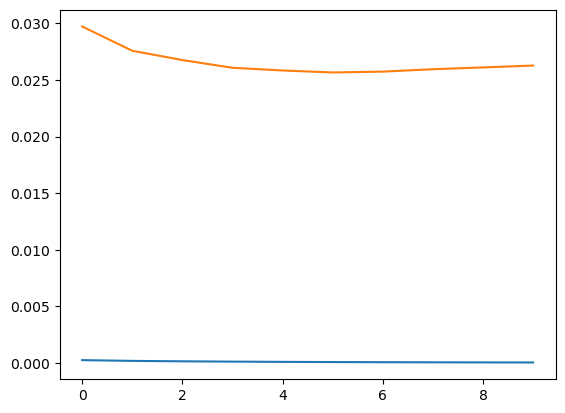

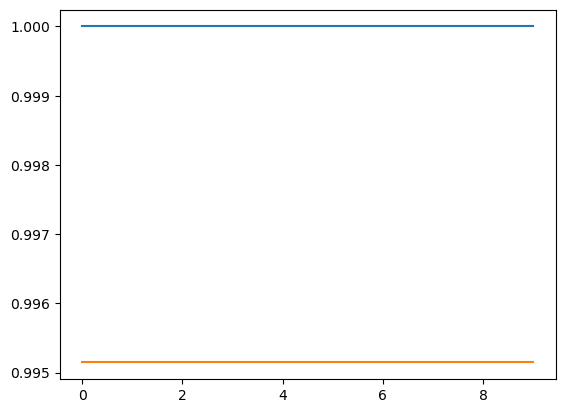

In [71]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plt.plot(train_loss)
plt.plot(val_loss)
plt.show()
plt.plot(train_acc)
plt.plot(val_acc)
plt.show()

In [79]:
model.save(os.path.join("models", "building_recognition_transf_v1.h5"))

In [80]:
class_names

['building', 'not building']

In [ ]:
# test sample images:
import os
import numpy as np
import matplotlib.pyplot as plt
SAMPLE_DIR = os.path.join('sample_images', 'building testing')

ds_testing = tf.keras.preprocessing.image_dataset_from_directory(
    SAMPLE_DIR,
    label_mode=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=None
)

In [77]:
def get_prediction(prediction, _class_names):
    one_hot_array = prediction[0]
    max_confidence = max(one_hot_array)
    if max_confidence < 0.5:
        return 'unsure'
    else:
        return _class_names[one_hot_array.argmax()]

In [ ]:
for images in ds_testing:
    for i in range(25):
        try:
            image = images[i]
            plt.imshow(image.numpy().astype("uint8"))
            predictions = model.predict(np.expand_dims(image, axis=0))
            plt.title(get_prediction(predictions, class_names))
            plt.show()
        except Exception as e:
            print(e)